In [52]:
import torch
import time
import subprocess
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
import numpy as np
# import argparse
import time
import pandas as pd
from helpers import timeSince, asMinutes, calc_auc
from vi_model import *
# import h5py
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# from baseline_model import *

class Arg():
    def __init__(self):
        pass

args = Arg()
args.model_type = 0
args.latent_dim = 2
args.batch_size = 56
args.num_epochs = 1000
args.clip = 50.0
args.learning_rate1 = 0.001
args.learning_rate2 = 0.001
args.alpha = 1.0
args.model_file = 'stupidvi.pkl'
args.init_stdev = 0.01

expn_pth = '/n/data_02/Basset/data/expn/roadmap/57epigenomes.RPKM.pc'
print("Reading gene expression data from:\n{}".format(expn_pth))
# Gene expression dataset
expn = pd.read_table(expn_pth,header=0)
col_names = expn.columns.values[1:]
expn = expn.drop(col_names[-1],axis=1) # 19795*57 right now # TODO: is this all right?
expn.columns = col_names
pinned_lookup = torch.nn.Embedding.from_pretrained(torch.FloatTensor(expn.as_matrix().T[1:]),freeze=True) # [1:] is new!
pinned_lookup.cuda()

torch.manual_seed(3435)
imgs = torch.poisson(pinned_lookup.weight) # discretize data
# imgs = pinned_lookup.weight.round()
# imgs = pinned_lookup.weight
dat = torch.utils.data.TensorDataset(imgs, torch.zeros(56,1)) # placeholder arg required pytorch <0.4.0...
loader = torch.utils.data.DataLoader(dat, batch_size=args.batch_size, shuffle=False)
img, _ = next(iter(loader))
print(img.size())

theta = Decoder(latent_dim=args.latent_dim)
if True: # initialize weights with smaller stdev to prevent instability
    dsd = theta.state_dict()
    for param in dsd:
        dsd[param].data = torch.randn(dsd[param].size())*args.init_stdev
    theta.load_state_dict(dsd)

theta.cuda()
# theta.load_state_dict(torch.load(args.model_file))

criterion = nn.PoissonNLLLoss(log_input=True, size_average=False, full=True)
optim1 = torch.optim.SGD(theta.parameters(), lr = args.learning_rate1)
p = Normal(Variable(torch.zeros(args.batch_size, args.latent_dim)).cuda(), 
           Variable(torch.ones(args.batch_size, args.latent_dim)).cuda()) # p(z)
mu = Variable(torch.randn(args.batch_size,args.latent_dim).cuda(),requires_grad=True) # variational parameters
logvar = Variable(torch.randn(args.batch_size,args.latent_dim).cuda(),requires_grad=True)
optim2 = torch.optim.SGD([mu,logvar], lr = args.learning_rate2)


Reading gene expression data from:
/n/data_02/Basset/data/expn/roadmap/57epigenomes.RPKM.pc
torch.Size([56, 19795])


In [53]:
optim1.zero_grad()
optim2.zero_grad()
q = Normal(loc=mu, scale=logvar.mul(0.5).exp())
# Reparameterized sample.
qsamp = q.rsample()
kl = kl_divergence(q, p).sum() # KL term
out = theta(qsamp)
recon_loss = criterion(out, img) # reconstruction term
loss = (recon_loss + args.alpha * kl) / args.batch_size

In [47]:
j = out.exp()-img*out
assert(j.sum().item()==recon_loss.item())

AssertionError: 

Text(0,0.5,'Unnormalized Loss Scores')

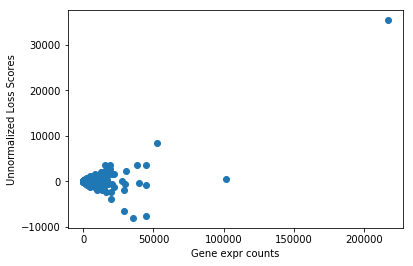

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
a = img.cpu().numpy().flatten()
b = j.cpu().detach().numpy().flatten()
plt.plot(a,b,'o')
plt.xlabel('Gene expr counts')
plt.ylabel('Unnormalized Loss Scores')
# plt.xlim(0,10)
# plt.ylim(-10,10)

(0, 1000)

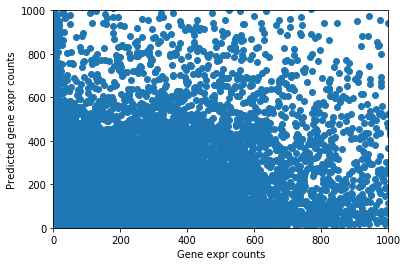

In [58]:
c = out.exp().detach().cpu().numpy().flatten()
plt.plot(a,c,'o')
plt.xlabel('Gene expr counts')
plt.ylabel('Predicted gene expr counts')
plt.xlim(0,1000)
plt.ylim(0,1000)

In [59]:
(img>400).sum()

tensor(4124, device='cuda:0')

In [55]:
# TODO: to make this stochastic, shuffle and make smaller batches.
start = time.time()
theta.train()
for epoch in range(args.num_epochs):
    # Keep track of reconstruction loss and total kl
    total_recon_loss = 0
    total_kl = 0
    total = 0
    for img, _ in loader:
        # no need to Variable(img).cuda()
        optim1.zero_grad()
        optim2.zero_grad()
        q = Normal(loc=mu, scale=logvar.mul(0.5).exp())
        # Reparameterized sample.
        qsamp = q.rsample()
        kl = kl_divergence(q, p).sum() # KL term
        out = theta(qsamp)
        recon_loss = criterion(out, img) # reconstruction term
        loss = (recon_loss + args.alpha * kl) / args.batch_size
        total_recon_loss += recon_loss.item() / args.batch_size
        total_kl += kl.item() / args.batch_size
        total += 1
        loss.backward()
        if args.clip:
            torch.nn.utils.clip_grad_norm_(theta.parameters(), args.clip)
            torch.nn.utils.clip_grad_norm_(mu, args.clip)
            torch.nn.utils.clip_grad_norm_(theta.parameters(), args.clip)
        if epoch % 2:
            optim1.step()
            wv = 'Theta'
            # print(theta.linear1.weight[:56:4])
            # print(theta.linear2.weight)
        else:
            optim2.step()
            wv = 'Lambda'
            # print(mu[:56:4])
            # print(logvar[:56:4])
    timenow = timeSince(start)
    print ('Time %s, Epoch [%d/%d], Tuning %s, Recon Loss: %.4f, KL Loss: %.4f, ELBO Loss: %.4f' 
            %(timenow, (epoch+2)//2, args.num_epochs, wv, total_recon_loss/total , total_kl/total, (total_recon_loss+total_kl)/total))
    # TODO: add eval loop for big VAE
torch.save(theta.state_dict(), args.model_file)
#     np.save('mu',mu.detach().numpy())
#     np.save('logvar',logvar.detach().numpy())

Time 0m 0s, Epoch [1/1000], Tuning Lambda, Recon Loss: 1545598.7143, KL Loss: 1.6946, ELBO Loss: 1545600.4089
Time 0m 0s, Epoch [1/1000], Tuning Theta, Recon Loss: 1545598.8571, KL Loss: 1.6945, ELBO Loss: 1545600.5516
Time 0m 0s, Epoch [2/1000], Tuning Lambda, Recon Loss: 1540490.0000, KL Loss: 1.6945, ELBO Loss: 1540491.6945
Time 0m 0s, Epoch [2/1000], Tuning Theta, Recon Loss: 1540497.0000, KL Loss: 1.6943, ELBO Loss: 1540498.6943
Time 0m 0s, Epoch [3/1000], Tuning Lambda, Recon Loss: 1535386.2857, KL Loss: 1.6943, ELBO Loss: 1535387.9800
Time 0m 0s, Epoch [3/1000], Tuning Theta, Recon Loss: 1535395.0000, KL Loss: 1.6942, ELBO Loss: 1535396.6942
Time 0m 0s, Epoch [4/1000], Tuning Lambda, Recon Loss: 1530275.7143, KL Loss: 1.6942, ELBO Loss: 1530277.4084
Time 0m 0s, Epoch [4/1000], Tuning Theta, Recon Loss: 1530281.7143, KL Loss: 1.6941, ELBO Loss: 1530283.4084
Time 0m 0s, Epoch [5/1000], Tuning Lambda, Recon Loss: 1525170.0000, KL Loss: 1.6941, ELBO Loss: 1525171.6941
Time 0m 0s, Ep

Time 0m 0s, Epoch [39/1000], Tuning Theta, Recon Loss: 1354369.8571, KL Loss: 1.8240, ELBO Loss: 1354371.6811
Time 0m 0s, Epoch [40/1000], Tuning Lambda, Recon Loss: 1349679.4286, KL Loss: 1.8240, ELBO Loss: 1349681.2526
Time 0m 0s, Epoch [40/1000], Tuning Theta, Recon Loss: 1349796.2857, KL Loss: 1.8406, ELBO Loss: 1349798.1263
Time 0m 0s, Epoch [41/1000], Tuning Lambda, Recon Loss: 1344865.2857, KL Loss: 1.8406, ELBO Loss: 1344867.1263
Time 0m 0s, Epoch [41/1000], Tuning Theta, Recon Loss: 1346146.5714, KL Loss: 1.8616, ELBO Loss: 1346148.4331
Time 0m 0s, Epoch [42/1000], Tuning Lambda, Recon Loss: 1340247.8571, KL Loss: 1.8616, ELBO Loss: 1340249.7188
Time 0m 0s, Epoch [42/1000], Tuning Theta, Recon Loss: 1340689.1429, KL Loss: 1.8872, ELBO Loss: 1340691.0300
Time 0m 0s, Epoch [43/1000], Tuning Lambda, Recon Loss: 1336945.2857, KL Loss: 1.8872, ELBO Loss: 1336947.1729
Time 0m 0s, Epoch [43/1000], Tuning Theta, Recon Loss: 1335008.4286, KL Loss: 1.9031, ELBO Loss: 1335010.3317
Time 0

Time 0m 0s, Epoch [78/1000], Tuning Theta, Recon Loss: 1156928.4286, KL Loss: 8.4332, ELBO Loss: 1156936.8618
Time 0m 0s, Epoch [79/1000], Tuning Lambda, Recon Loss: 1151244.3571, KL Loss: 8.4332, ELBO Loss: 1151252.7903
Time 0m 0s, Epoch [79/1000], Tuning Theta, Recon Loss: 1149618.7857, KL Loss: 8.9027, ELBO Loss: 1149627.6884
Time 0m 0s, Epoch [80/1000], Tuning Lambda, Recon Loss: 1146623.8571, KL Loss: 8.9027, ELBO Loss: 1146632.7599
Time 0m 0s, Epoch [80/1000], Tuning Theta, Recon Loss: 1146490.0000, KL Loss: 9.2864, ELBO Loss: 1146499.2864
Time 0m 0s, Epoch [81/1000], Tuning Lambda, Recon Loss: 1138865.7857, KL Loss: 9.2864, ELBO Loss: 1138875.0721
Time 0m 0s, Epoch [81/1000], Tuning Theta, Recon Loss: 1141764.8571, KL Loss: 9.6285, ELBO Loss: 1141774.4857
Time 0m 0s, Epoch [82/1000], Tuning Lambda, Recon Loss: 1134814.5000, KL Loss: 9.6285, ELBO Loss: 1134824.1285
Time 0m 0s, Epoch [82/1000], Tuning Theta, Recon Loss: 1133804.9286, KL Loss: 10.3105, ELBO Loss: 1133815.2390
Time 

Time 0m 1s, Epoch [116/1000], Tuning Theta, Recon Loss: 900796.8571, KL Loss: 43.0723, ELBO Loss: 900839.9294
Time 0m 1s, Epoch [117/1000], Tuning Lambda, Recon Loss: 896343.6429, KL Loss: 43.0723, ELBO Loss: 896386.7151
Time 0m 1s, Epoch [117/1000], Tuning Theta, Recon Loss: 895514.1429, KL Loss: 44.6643, ELBO Loss: 895558.8071
Time 0m 1s, Epoch [118/1000], Tuning Lambda, Recon Loss: 889137.7143, KL Loss: 44.6643, ELBO Loss: 889182.3786
Time 0m 1s, Epoch [118/1000], Tuning Theta, Recon Loss: 887960.2143, KL Loss: 45.8094, ELBO Loss: 888006.0237
Time 0m 1s, Epoch [119/1000], Tuning Lambda, Recon Loss: 881166.5000, KL Loss: 45.8094, ELBO Loss: 881212.3094
Time 0m 1s, Epoch [119/1000], Tuning Theta, Recon Loss: 880786.7143, KL Loss: 47.0310, ELBO Loss: 880833.7453
Time 0m 1s, Epoch [120/1000], Tuning Lambda, Recon Loss: 875704.0714, KL Loss: 47.0310, ELBO Loss: 875751.1024
Time 0m 1s, Epoch [120/1000], Tuning Theta, Recon Loss: 874190.8571, KL Loss: 48.4672, ELBO Loss: 874239.3243
Time 0

Time 0m 1s, Epoch [155/1000], Tuning Theta, Recon Loss: 639881.9286, KL Loss: 103.4004, ELBO Loss: 639985.3290
Time 0m 1s, Epoch [156/1000], Tuning Lambda, Recon Loss: 634187.5714, KL Loss: 103.4004, ELBO Loss: 634290.9719
Time 0m 1s, Epoch [156/1000], Tuning Theta, Recon Loss: 633070.4286, KL Loss: 104.6315, ELBO Loss: 633175.0601
Time 0m 1s, Epoch [157/1000], Tuning Lambda, Recon Loss: 628930.3571, KL Loss: 104.6315, ELBO Loss: 629034.9886
Time 0m 1s, Epoch [157/1000], Tuning Theta, Recon Loss: 628606.5714, KL Loss: 106.1406, ELBO Loss: 628712.7120
Time 0m 1s, Epoch [158/1000], Tuning Lambda, Recon Loss: 622885.2143, KL Loss: 106.1406, ELBO Loss: 622991.3549
Time 0m 1s, Epoch [158/1000], Tuning Theta, Recon Loss: 620847.1429, KL Loss: 108.6870, ELBO Loss: 620955.8298
Time 0m 1s, Epoch [159/1000], Tuning Lambda, Recon Loss: 616654.8571, KL Loss: 108.6870, ELBO Loss: 616763.5441
Time 0m 1s, Epoch [159/1000], Tuning Theta, Recon Loss: 615530.7857, KL Loss: 109.9365, ELBO Loss: 615640.72

Time 0m 2s, Epoch [194/1000], Tuning Theta, Recon Loss: 496340.8214, KL Loss: 151.6168, ELBO Loss: 496492.4382
Time 0m 2s, Epoch [195/1000], Tuning Lambda, Recon Loss: 492246.4643, KL Loss: 151.6168, ELBO Loss: 492398.0810
Time 0m 2s, Epoch [195/1000], Tuning Theta, Recon Loss: 492095.5000, KL Loss: 151.7837, ELBO Loss: 492247.2837
Time 0m 2s, Epoch [196/1000], Tuning Lambda, Recon Loss: 491763.7857, KL Loss: 151.7837, ELBO Loss: 491915.5694
Time 0m 2s, Epoch [196/1000], Tuning Theta, Recon Loss: 492018.3214, KL Loss: 153.5040, ELBO Loss: 492171.8254
Time 0m 2s, Epoch [197/1000], Tuning Lambda, Recon Loss: 488001.8214, KL Loss: 153.5040, ELBO Loss: 488155.3254
Time 0m 2s, Epoch [197/1000], Tuning Theta, Recon Loss: 487529.1429, KL Loss: 153.5834, ELBO Loss: 487682.7262
Time 0m 2s, Epoch [198/1000], Tuning Lambda, Recon Loss: 487712.3571, KL Loss: 153.5834, ELBO Loss: 487865.9405
Time 0m 2s, Epoch [198/1000], Tuning Theta, Recon Loss: 487121.1071, KL Loss: 155.5404, ELBO Loss: 487276.64

Time 0m 2s, Epoch [233/1000], Tuning Lambda, Recon Loss: 426203.9286, KL Loss: 183.6213, ELBO Loss: 426387.5498
Time 0m 2s, Epoch [233/1000], Tuning Theta, Recon Loss: 426079.8214, KL Loss: 183.1636, ELBO Loss: 426262.9851
Time 0m 2s, Epoch [234/1000], Tuning Lambda, Recon Loss: 428549.7143, KL Loss: 183.1636, ELBO Loss: 428732.8779
Time 0m 2s, Epoch [234/1000], Tuning Theta, Recon Loss: 428141.9286, KL Loss: 184.8094, ELBO Loss: 428326.7379
Time 0m 2s, Epoch [235/1000], Tuning Lambda, Recon Loss: 423916.3214, KL Loss: 184.8094, ELBO Loss: 424101.1308
Time 0m 2s, Epoch [235/1000], Tuning Theta, Recon Loss: 423819.6429, KL Loss: 184.3533, ELBO Loss: 424003.9961
Time 0m 2s, Epoch [236/1000], Tuning Lambda, Recon Loss: 426515.2143, KL Loss: 184.3533, ELBO Loss: 426699.5675
Time 0m 2s, Epoch [236/1000], Tuning Theta, Recon Loss: 425919.9286, KL Loss: 186.3069, ELBO Loss: 426106.2355
Time 0m 2s, Epoch [237/1000], Tuning Lambda, Recon Loss: 421190.0714, KL Loss: 186.3069, ELBO Loss: 421376.3

Time 0m 2s, Epoch [272/1000], Tuning Lambda, Recon Loss: 393356.4643, KL Loss: 205.8849, ELBO Loss: 393562.3492
Time 0m 2s, Epoch [272/1000], Tuning Theta, Recon Loss: 392675.0357, KL Loss: 207.4544, ELBO Loss: 392882.4901
Time 0m 2s, Epoch [273/1000], Tuning Lambda, Recon Loss: 388103.8214, KL Loss: 207.4544, ELBO Loss: 388311.2758
Time 0m 2s, Epoch [273/1000], Tuning Theta, Recon Loss: 387599.2857, KL Loss: 206.7845, ELBO Loss: 387806.0702
Time 0m 2s, Epoch [274/1000], Tuning Lambda, Recon Loss: 391562.1071, KL Loss: 206.7845, ELBO Loss: 391768.8917
Time 0m 2s, Epoch [274/1000], Tuning Theta, Recon Loss: 391158.8929, KL Loss: 208.2437, ELBO Loss: 391367.1365
Time 0m 2s, Epoch [275/1000], Tuning Lambda, Recon Loss: 386330.6429, KL Loss: 208.2437, ELBO Loss: 386538.8865
Time 0m 2s, Epoch [275/1000], Tuning Theta, Recon Loss: 386289.6786, KL Loss: 207.5944, ELBO Loss: 386497.2730
Time 0m 2s, Epoch [276/1000], Tuning Lambda, Recon Loss: 390332.0714, KL Loss: 207.5944, ELBO Loss: 390539.6

Time 0m 3s, Epoch [311/1000], Tuning Lambda, Recon Loss: 366056.6071, KL Loss: 223.4374, ELBO Loss: 366280.0446
Time 0m 3s, Epoch [311/1000], Tuning Theta, Recon Loss: 365903.9286, KL Loss: 222.3546, ELBO Loss: 366126.2832
Time 0m 3s, Epoch [312/1000], Tuning Lambda, Recon Loss: 370690.1429, KL Loss: 222.3546, ELBO Loss: 370912.4974
Time 0m 3s, Epoch [312/1000], Tuning Theta, Recon Loss: 370322.1786, KL Loss: 223.6561, ELBO Loss: 370545.8347
Time 0m 3s, Epoch [313/1000], Tuning Lambda, Recon Loss: 365129.3214, KL Loss: 223.6561, ELBO Loss: 365352.9776
Time 0m 3s, Epoch [313/1000], Tuning Theta, Recon Loss: 364955.2143, KL Loss: 222.9448, ELBO Loss: 365178.1591
Time 0m 3s, Epoch [314/1000], Tuning Lambda, Recon Loss: 369953.1786, KL Loss: 222.9448, ELBO Loss: 370176.1233
Time 0m 3s, Epoch [314/1000], Tuning Theta, Recon Loss: 369788.0714, KL Loss: 224.4510, ELBO Loss: 370012.5225
Time 0m 3s, Epoch [315/1000], Tuning Lambda, Recon Loss: 364195.5357, KL Loss: 224.4510, ELBO Loss: 364419.9

Time 0m 3s, Epoch [349/1000], Tuning Lambda, Recon Loss: 351649.6429, KL Loss: 233.7102, ELBO Loss: 351883.3531
Time 0m 3s, Epoch [349/1000], Tuning Theta, Recon Loss: 351467.6429, KL Loss: 232.7093, ELBO Loss: 351700.3522
Time 0m 3s, Epoch [350/1000], Tuning Lambda, Recon Loss: 356857.2857, KL Loss: 232.7093, ELBO Loss: 357089.9950
Time 0m 3s, Epoch [350/1000], Tuning Theta, Recon Loss: 356520.1786, KL Loss: 234.2129, ELBO Loss: 356754.3915
Time 0m 3s, Epoch [351/1000], Tuning Lambda, Recon Loss: 350702.0357, KL Loss: 234.2129, ELBO Loss: 350936.2487
Time 0m 3s, Epoch [351/1000], Tuning Theta, Recon Loss: 350789.2500, KL Loss: 233.7849, ELBO Loss: 351023.0349
Time 0m 3s, Epoch [352/1000], Tuning Lambda, Recon Loss: 356032.7857, KL Loss: 233.7849, ELBO Loss: 356266.5707
Time 0m 3s, Epoch [352/1000], Tuning Theta, Recon Loss: 355742.0357, KL Loss: 234.6732, ELBO Loss: 355976.7089
Time 0m 3s, Epoch [353/1000], Tuning Lambda, Recon Loss: 350212.5357, KL Loss: 234.6732, ELBO Loss: 350447.2

Time 0m 4s, Epoch [387/1000], Tuning Lambda, Recon Loss: 339780.6429, KL Loss: 241.5246, ELBO Loss: 340022.1674
Time 0m 4s, Epoch [387/1000], Tuning Theta, Recon Loss: 339651.2143, KL Loss: 240.8695, ELBO Loss: 339892.0837
Time 0m 4s, Epoch [388/1000], Tuning Lambda, Recon Loss: 345519.8214, KL Loss: 240.8695, ELBO Loss: 345760.6909
Time 0m 4s, Epoch [388/1000], Tuning Theta, Recon Loss: 344599.6786, KL Loss: 242.3486, ELBO Loss: 344842.0272
Time 0m 4s, Epoch [389/1000], Tuning Lambda, Recon Loss: 339434.4643, KL Loss: 242.3486, ELBO Loss: 339676.8129
Time 0m 4s, Epoch [389/1000], Tuning Theta, Recon Loss: 338827.0000, KL Loss: 241.0552, ELBO Loss: 339068.0552
Time 0m 4s, Epoch [390/1000], Tuning Lambda, Recon Loss: 344657.6071, KL Loss: 241.0552, ELBO Loss: 344898.6623
Time 0m 4s, Epoch [390/1000], Tuning Theta, Recon Loss: 344247.3214, KL Loss: 242.3714, ELBO Loss: 344489.6928
Time 0m 4s, Epoch [391/1000], Tuning Lambda, Recon Loss: 338738.7500, KL Loss: 242.3714, ELBO Loss: 338981.1

Time 0m 4s, Epoch [425/1000], Tuning Lambda, Recon Loss: 330082.4643, KL Loss: 246.2351, ELBO Loss: 330328.6994
Time 0m 4s, Epoch [425/1000], Tuning Theta, Recon Loss: 329194.3929, KL Loss: 244.6681, ELBO Loss: 329439.0609
Time 0m 4s, Epoch [426/1000], Tuning Lambda, Recon Loss: 335863.6071, KL Loss: 244.6681, ELBO Loss: 336108.2752
Time 0m 4s, Epoch [426/1000], Tuning Theta, Recon Loss: 332752.9643, KL Loss: 246.0599, ELBO Loss: 332999.0242
Time 0m 4s, Epoch [427/1000], Tuning Lambda, Recon Loss: 328949.5357, KL Loss: 246.0599, ELBO Loss: 329195.5956
Time 0m 4s, Epoch [427/1000], Tuning Theta, Recon Loss: 328169.2857, KL Loss: 244.7431, ELBO Loss: 328414.0288
Time 0m 4s, Epoch [428/1000], Tuning Lambda, Recon Loss: 334304.7857, KL Loss: 244.7431, ELBO Loss: 334549.5288
Time 0m 4s, Epoch [428/1000], Tuning Theta, Recon Loss: 331394.6071, KL Loss: 245.9947, ELBO Loss: 331640.6019
Time 0m 4s, Epoch [429/1000], Tuning Lambda, Recon Loss: 328823.3929, KL Loss: 245.9947, ELBO Loss: 329069.3

Time 0m 4s, Epoch [463/1000], Tuning Theta, Recon Loss: 316816.5000, KL Loss: 240.2596, ELBO Loss: 317056.7596
Time 0m 4s, Epoch [464/1000], Tuning Lambda, Recon Loss: 319877.5714, KL Loss: 240.2596, ELBO Loss: 320117.8310
Time 0m 4s, Epoch [464/1000], Tuning Theta, Recon Loss: 318110.1071, KL Loss: 240.5315, ELBO Loss: 318350.6386
Time 0m 4s, Epoch [465/1000], Tuning Lambda, Recon Loss: 320226.2500, KL Loss: 240.5315, ELBO Loss: 320466.7815
Time 0m 4s, Epoch [465/1000], Tuning Theta, Recon Loss: 318223.9643, KL Loss: 238.9866, ELBO Loss: 318462.9508
Time 0m 4s, Epoch [466/1000], Tuning Lambda, Recon Loss: 323244.3214, KL Loss: 238.9866, ELBO Loss: 323483.3080
Time 0m 4s, Epoch [466/1000], Tuning Theta, Recon Loss: 319843.5000, KL Loss: 237.9051, ELBO Loss: 320081.4051
Time 0m 4s, Epoch [467/1000], Tuning Lambda, Recon Loss: 315855.7500, KL Loss: 237.9051, ELBO Loss: 316093.6551
Time 0m 4s, Epoch [467/1000], Tuning Theta, Recon Loss: 315062.2857, KL Loss: 239.4814, ELBO Loss: 315301.76

In [62]:
mu

tensor([[-19.8358,  -3.2132],
        [-20.4740,  -2.6304],
        [-20.1747,  -3.9908],
        [-20.5582,  -2.7753],
        [-19.8447,  -4.1608],
        [-19.2309,  -3.3603],
        [-19.1651,  -1.2986],
        [-19.3200,  -4.1221],
        [-19.6241,  -3.8228],
        [-19.3140,  -4.4290],
        [-20.9129,  -5.0600],
        [-20.4306,  -4.5393],
        [-19.1436,  -4.2180],
        [-18.9953,  -3.6755],
        [-18.5873,  -5.0692],
        [-19.5302,  -3.9755],
        [-19.0413,  -4.5229],
        [-18.8076,  -4.2245],
        [-19.9354,  -6.2982],
        [-21.0219,  -6.9893],
        [-21.2579,  -7.6001],
        [-20.1886,  -5.8647],
        [-21.0341,  -8.7325],
        [-20.4210,  -5.2310],
        [-19.3326,  -5.2213],
        [-21.3605,  -3.5249],
        [-24.0209, -11.7843],
        [-20.0534,  -5.6536],
        [-19.9850,  -2.7525],
        [-21.3952,  -5.7620],
        [-18.9609,  -3.7753],
        [-19.1610,  -3.0971],
        [-19.2220,  -4.5424],
        [-

In [ ]:
# higher learning rates, bigger initialization, bigger grad norm, more epochs
# how does grad norm work?
# plotly viz

In [7]:
theta.linear2.weight.grad

tensor([[-1.5312e+01, -1.5323e+01, -1.5321e+01,  ..., -1.5337e+01,
         -1.5307e+01, -1.5322e+01],
        [ 1.7287e-01,  1.7240e-01,  1.7279e-01,  ...,  1.7330e-01,
          1.7208e-01,  1.7271e-01],
        [-2.7397e+01, -2.7413e+01, -2.7412e+01,  ..., -2.7443e+01,
         -2.7383e+01, -2.7413e+01],
        ...,
        [ 5.9593e-01,  5.9640e-01,  5.9630e-01,  ...,  5.9688e-01,
          5.9577e-01,  5.9634e-01],
        [ 6.8094e-01,  6.8142e-01,  6.8136e-01,  ...,  6.8206e-01,
          6.8065e-01,  6.8139e-01],
        [ 2.3233e-01,  2.3273e-01,  2.3261e-01,  ...,  2.3271e-01,
          2.3231e-01,  2.3266e-01]], device='cuda:0')

In [24]:
theta.linear2.weight.grad.norm(2)
theta.linear2.weight.grad.pow(2).sum().pow(0.5)

tensor(1.00000e+05 *
       1.0186, device='cuda:0')

In [16]:
parameters = theta.parameters()
parameters = list(filter(lambda p: p.grad is not None, parameters))
max_norm = float(5)
norm_type = float(2)
if norm_type == float('inf'):
    total_norm = max(p.grad.data.abs().max() for p in parameters)
else:
    total_norm = 0
    for p in parameters:
        param_norm = p.grad.data.norm(norm_type)
        total_norm += param_norm ** norm_type
        print(param_norm)
        print(total_norm)
    total_norm = total_norm ** (1. / norm_type)
clip_coef = max_norm / (total_norm + 1e-6)


tensor(77.4105, device='cuda:0')
tensor(5992.3867, device='cuda:0')
tensor(72.1575, device='cuda:0')
tensor(11199.0850, device='cuda:0')
tensor(1.00000e+05 *
       1.0186, device='cuda:0')
tensor(1.0376e+10, device='cuda:0')
tensor(10391.7725, device='cuda:0')
tensor(1.0484e+10, device='cuda:0')


In [19]:
clip_coef

tensor(1.00000e-05 *
       4.8832, device='cuda:0')

In [ ]:
if clip_coef < 1:
    for p in parameters:
        p.grad.data.mul_(clip_coef.item())
return total_norm

In [70]:
mumu = mu.cpu().detach().numpy()
col_names[1:]

array(['E003', 'E004', 'E005', 'E006', 'E007', 'E011', 'E012', 'E013',
       'E016', 'E024', 'E027', 'E028', 'E037', 'E038', 'E047', 'E050',
       'E053', 'E054', 'E055', 'E056', 'E057', 'E058', 'E059', 'E061',
       'E062', 'E065', 'E066', 'E070', 'E071', 'E079', 'E082', 'E084',
       'E085', 'E087', 'E094', 'E095', 'E096', 'E097', 'E098', 'E100',
       'E104', 'E105', 'E106', 'E109', 'E112', 'E113', 'E114', 'E116',
       'E117', 'E118', 'E119', 'E120', 'E122', 'E123', 'E127', 'E128'],
      dtype=object)

In [74]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

x = pd.Series(mumu[:,0])
y = pd.Series(mumu[:,1])

fps = go.Scatter(x=x, y=y,
    mode='markers',
    marker=dict(
        size=12,
        colorscale='Viridis',   # choose a colorscale
        opacity=0.3
    ),
    text=expn.columns.tolist()[1:]
)
data = [fps]
fig = dict(data=data)
from plotly.graph_objs import *
plotly.offline.plot(fig, filename='testpca.html')#, height=700, validate=False)

'file:///n/data_01/cs287-s18/projects/testpca.html'

In [71]:
!pip install plotly

    100% |████████████████████████████████| 25.0MB 51kB/s  eta 0:00:01
  Running setup.py bdist_wheel for plotly ... done
  Stored in directory: /home/sgosai/.cache/pip/wheels/25/eb/3f/c044ca0b88b6788754722358da17d60161152106a89102c5fb
Successfully built plotly
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
